In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Constants
e = 1.602176634e-19                   # Elementary charge (C)
m_e = 9.10938356e-31                  # Electron mass (kg)
hbar = 1.054571817e-34                # Reduced Planck's constant (J·s)
c = 3e8                               # Speed of light

gamma_1 = 0.39 * e                    # Interlayer coupling energy (J)
gamma_0 = 3.1 * e                     # Intralayer coupling energy between A and B sites
gamma_3 = 0.315 * e
gamma_4 = 0.044 * e
delta_prime = 0.047 * e

B_const = 16                          # Constant Magnetic field (T)
# E_const_1 = -100 * 1e6                   # Constant Electric Field (mV/nm) 
E_const = 35 * 1e6
B_values = np.linspace(12, 18, 100)
E_values = np.linspace(0 * 1e6, 200 * 1e6 ,100)
n_values = list(range(2))

d = 3.35e-10
g = 2
a = 2.46e-10

v = (np.sqrt(3) * a * gamma_0) / (2 * hbar)     ## from T Chakraborty book
v3 = (np.sqrt(3) * a * gamma_3) / (2 * hbar)
v4 = (np.sqrt(3) * a * gamma_4) / (2 * hbar)

m_eff = gamma_1 / (2 * v**2)                    ## from T Chakraborty book
mu_B = (e * hbar) / (2 * m_eff)
# l_B = np.sqrt((hbar * c) / (e * B_const))

epsilon_0 = 8.854187817e-12
epsilon_parallel = 6.6
epsilon_perpendicular = 3

In [3]:
import scipy.integrate as integrate
import scipy.special as sp

def V_SC(q, epsilon_parallel, B, d):
    """Effective Coulomb interaction in BLG."""
    return (56.2/ epsilon_parallel) * (np.sqrt(B)) * (2 * np.pi / q) * np.tanh(q * d)  ## gives value in meV

def hankel_transform(V_SC, r, B):
    """Computes the 2D Fourier (Hankel) transform of V_SC(q)."""
    integrand = lambda q: q * V_SC(q, epsilon_parallel, B, d) * sp.j0(q * r)
    result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
    return result * 1e-3 * e

In [4]:
# Compute V(r) at r = 0 and r = a/3
r_A2 = a / np.sqrt(3)
r_B2 = 0

V_A2_const = hankel_transform(V_SC, r_A2, B_const)
V_B2_const = hankel_transform(V_SC, r_B2, B_const)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


## No Zeeman Splitting and No Electric field

In [5]:
# Store eigenvalues for all n
all_eigenvalues_K_var_B = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_K_prime_var_B = np.zeros((len(n_values), len(B_values), 4))

In [6]:
def hamiltonian_matrix_K_var_B(n, omega_B, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_K_var_B = np.array([
        [0, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2]
    ])
    return H_K_var_B

In [7]:
def hamiltonian_matrix_K_prime_var_B(n, omega_B, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_K_prime_var_B = np.array([
        [0, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), gamma_1, V_A2 + delta_prime, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2]
    ])
    return H_K_prime_var_B

In [8]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c) / (e * B))
        H_K_var_B = hamiltonian_matrix_K_var_B(n, omega_B, V_A2, V_B2, l_B)
        H_K_prime_var_B = hamiltonian_matrix_K_prime_var_B(n, omega_B, V_A2, V_B2, l_B)
        eigvals_K_var_B = np.linalg.eigvalsh(H_K_var_B) / e  # Convert to eV
        eigvals_K_prime_var_B = np.linalg.eigvalsh(H_K_prime_var_B) / e  # Convert to eV
        all_eigenvalues_K_var_B[i, j, :] = eigvals_K_var_B
        all_eigenvalues_K_prime_var_B[i, j, :] = eigvals_K_prime_var_B

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


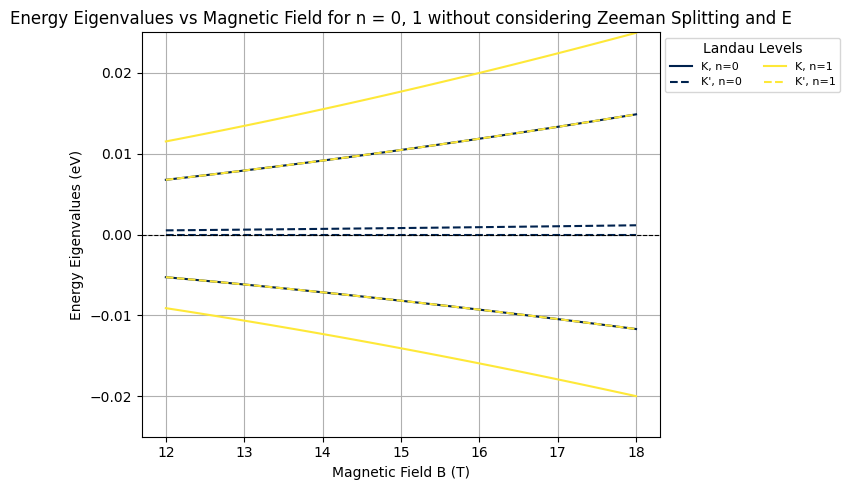

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.cividis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.025, 0.025)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 without considering Zeeman Splitting and E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
# plt.savefig("energy_vs_B_without_ZS_and_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

## Now considering Zeeman Splitting and not Electric field

In [10]:
# Store eigenvalues for all n
all_eigenvalues_ZS_K_var_B_spin_up = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_K_var_B_spin_down = np.zeros((len(n_values), len(B_values), 4))

all_eigenvalues_ZS_K_prime_var_B_spin_up = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_K_prime_var_B_spin_down = np.zeros((len(n_values), len(B_values), 4))

In [11]:
def hamiltonian_matrix_ZS_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    
    H_ZS_K_var_B_spin_up = np.array([
        [delta_ZS, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 + delta_ZS]
    ])

    H_ZS_K_var_B_spin_down = np.array([
        [-delta_ZS, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime - delta_ZS, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime - delta_ZS, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 - delta_ZS]
    ])
    return [H_ZS_K_var_B_spin_up , H_ZS_K_var_B_spin_down]

In [12]:
def hamiltonian_matrix_ZS_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    
    H_ZS_K_prime_var_B_spin_up = np.array([
        [delta_ZS, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, V_A2 + delta_prime + delta_ZS, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 + delta_ZS]
    ])

    H_ZS_K_prime_var_B_spin_down = np.array([
        [-delta_ZS, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime - delta_ZS, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, V_A2 + delta_prime - delta_ZS, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 - delta_ZS]
    ])
    return [H_ZS_K_prime_var_B_spin_up, H_ZS_K_prime_var_B_spin_down]

In [13]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        delta_ZS = g * mu_B * B
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c)/ (e * B))
        
        H_ZS_K_var_B_spin_up = hamiltonian_matrix_ZS_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[0]
        H_ZS_K_var_B_spin_down = hamiltonian_matrix_ZS_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[1]
        
        H_ZS_K_prime_var_B_spin_up = hamiltonian_matrix_ZS_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[0]
        H_ZS_K_prime_var_B_spin_down = hamiltonian_matrix_ZS_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[1]
        
        eigvals_ZS_K_var_B_spin_up = np.linalg.eigvalsh(H_ZS_K_var_B_spin_up) / e  # Convert to eV
        eigvals_ZS_K_var_B_spin_down = np.linalg.eigvalsh(H_ZS_K_var_B_spin_down) / e  # Convert to eV
        
        eigvals_ZS_K_prime_var_B_spin_up = np.linalg.eigvalsh(H_ZS_K_prime_var_B_spin_up) / e  # Convert to eV
        eigvals_ZS_K_prime_var_B_spin_down = np.linalg.eigvalsh(H_ZS_K_prime_var_B_spin_down) / e  # Convert to eV
        
        all_eigenvalues_ZS_K_var_B_spin_up[i, j, :] = eigvals_ZS_K_var_B_spin_up
        all_eigenvalues_ZS_K_var_B_spin_down[i, j, :] = eigvals_ZS_K_var_B_spin_down
        
        all_eigenvalues_ZS_K_prime_var_B_spin_up[i, j, :] = eigvals_ZS_K_prime_var_B_spin_up
        all_eigenvalues_ZS_K_prime_var_B_spin_down[i, j, :] = eigvals_ZS_K_prime_var_B_spin_down

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


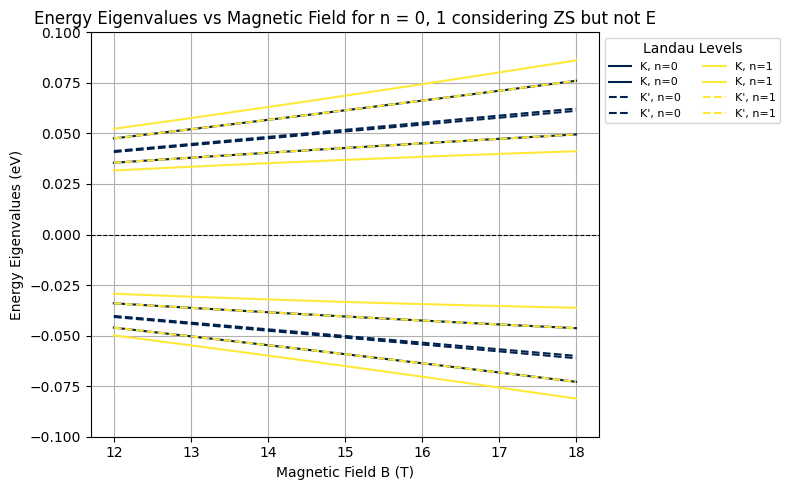

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.cividis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 considering ZS but not E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
# plt.savefig("energy_vs_B_considering_ZS_but_not_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

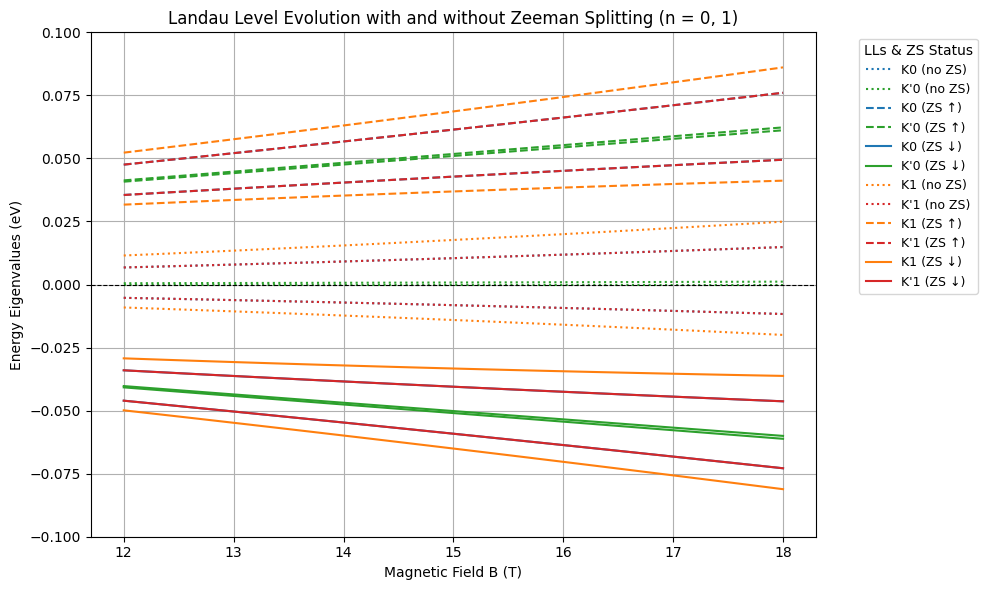

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define labels and color map
colors = {
    'K0': 'tab:blue',
    'K1': 'tab:orange',
    "K'0": 'tab:green',
    "K'1": 'tab:red'
}

# Line styles for different cases
linestyles = {
    'no_ZS': ':',
    'ZS_up': '--',
    'ZS_down': '-'
}

for i, n in enumerate(n_values):  # n = 0, 1
    label_K = f'K{n}'
    label_Kp = f"K'{n}"
    color_K = colors[label_K]
    color_Kp = colors[label_Kp]

    for mode in range(4):
        if mode == 0:
            # No Zeeman
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=color_K, linestyle=linestyles['no_ZS'], label=f'{label_K} (no ZS)')
            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=color_Kp, linestyle=linestyles['no_ZS'], label=f"{label_Kp} (no ZS)")

            # Zeeman spin-up
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_up'], label=f'{label_K} (ZS ↑)')
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_up'], label=f"{label_Kp} (ZS ↑)")

            # Zeeman spin-down
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_down'], label=f'{label_K} (ZS ↓)')
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_down'], label=f"{label_Kp} (ZS ↓)")
        else:
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=color_K, linestyle=linestyles['no_ZS'])
            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=color_Kp, linestyle=linestyles['no_ZS'])

            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_up'])
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_up'])

            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_down'])
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_down'])

# Aesthetics
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title('Landau Level Evolution with and without Zeeman Splitting (n = 0, 1)')
ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax.grid(True)

# Construct legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title="LLs & ZS Status")
plt.tight_layout()
plt.show()

## Now considering both Zeeman Splitting and Electric field

In [16]:
# Store eigenvalues for all n
all_eigenvalues_ZS_EF_K_var_B_spin_up = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_EF_K_var_B_spin_down = np.zeros((len(n_values), len(B_values), 4))

all_eigenvalues_ZS_EF_K_prime_var_B_spin_up = np.zeros((len(n_values), len(B_values), 4))
all_eigenvalues_ZS_EF_K_prime_var_B_spin_down = np.zeros((len(n_values), len(B_values), 4))

In [17]:
def hamiltonian_matrix_ZS_EF_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    potential_diff_const = e * E_const * d/2
    
    H_ZS_EF_K_var_B_spin_up = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 + delta_ZS - potential_diff_const]
    ])

    H_ZS_EF_K_var_B_spin_down = np.array([
        [-delta_ZS + potential_diff_const, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime - delta_ZS + potential_diff_const, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, V_A2 + delta_prime - delta_ZS - potential_diff_const, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, V_B2 - delta_ZS - potential_diff_const]
    ])
    return [H_ZS_EF_K_var_B_spin_up , H_ZS_EF_K_var_B_spin_down]

In [18]:
def hamiltonian_matrix_ZS_EF_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    potential_diff_const = e * E_const * d/2
    
    H_ZS_EF_K_prime_var_B_spin_up = np.array([
        [delta_ZS + potential_diff_const, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff_const, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, V_A2 + delta_prime + delta_ZS - potential_diff_const, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 + delta_ZS - potential_diff_const]
    ])

    H_ZS_EF_K_prime_var_B_spin_down = np.array([
        [-delta_ZS + potential_diff_const, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime - delta_ZS + potential_diff_const, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, V_A2 + delta_prime - delta_ZS - potential_diff_const, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, V_B2 - delta_ZS - potential_diff_const]
    ])
    return [H_ZS_EF_K_prime_var_B_spin_up, H_ZS_EF_K_prime_var_B_spin_down]

In [19]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, B in enumerate(B_values):
        omega_B = e * B / m_eff
        delta_ZS = g * mu_B * B
        V_A2 = hankel_transform(V_SC, r_A2, B)
        V_B2 = hankel_transform(V_SC, r_B2, B)
        l_B = np.sqrt((hbar * c)/ (e * B))
        
        H_ZS_EF_K_var_B_spin_up = hamiltonian_matrix_ZS_EF_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[0]
        H_ZS_EF_K_var_B_spin_down = hamiltonian_matrix_ZS_EF_K_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[1]
        
        H_ZS_EF_K_prime_var_B_spin_up = hamiltonian_matrix_ZS_EF_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[0]
        H_ZS_EF_K_prime_var_B_spin_down = hamiltonian_matrix_ZS_EF_K_prime_var_B(n, omega_B, delta_ZS, V_A2, V_B2, l_B)[1]
        
        eigvals_ZS_EF_K_var_B_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_var_B_spin_up) / e  # Convert to eV
        eigvals_ZS_EF_K_var_B_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_var_B_spin_down) / e  # Convert to eV
        
        eigvals_ZS_EF_K_prime_var_B_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B_spin_up) / e  # Convert to eV
        eigvals_ZS_EF_K_prime_var_B_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B_spin_down) / e  # Convert to eV
        
        all_eigenvalues_ZS_EF_K_var_B_spin_up[i, j, :] = eigvals_ZS_EF_K_var_B_spin_up
        all_eigenvalues_ZS_EF_K_var_B_spin_down[i, j, :] = eigvals_ZS_EF_K_var_B_spin_down
        
        all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i, j, :] = eigvals_ZS_EF_K_prime_var_B_spin_up
        all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i, j, :] = eigvals_ZS_EF_K_prime_var_B_spin_down

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


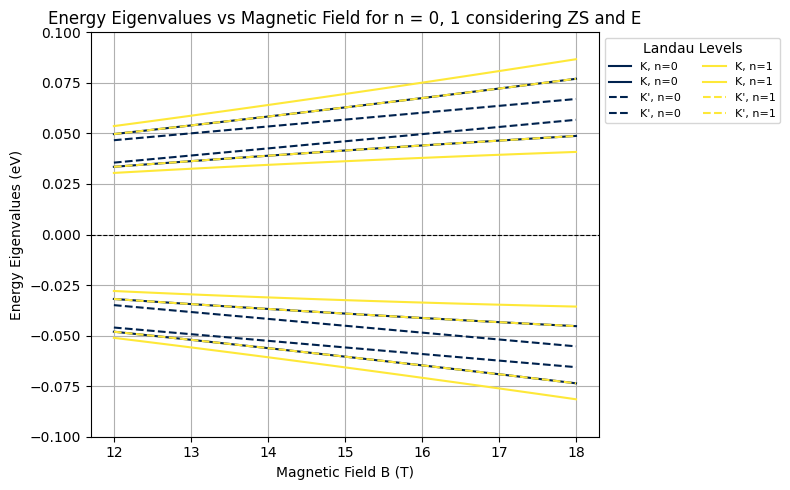

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.cividis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_up[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_down[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")
        ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n = 0, 1 considering ZS and E')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
# plt.savefig("energy_vs_B_considering_ZS_but_not_E.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()

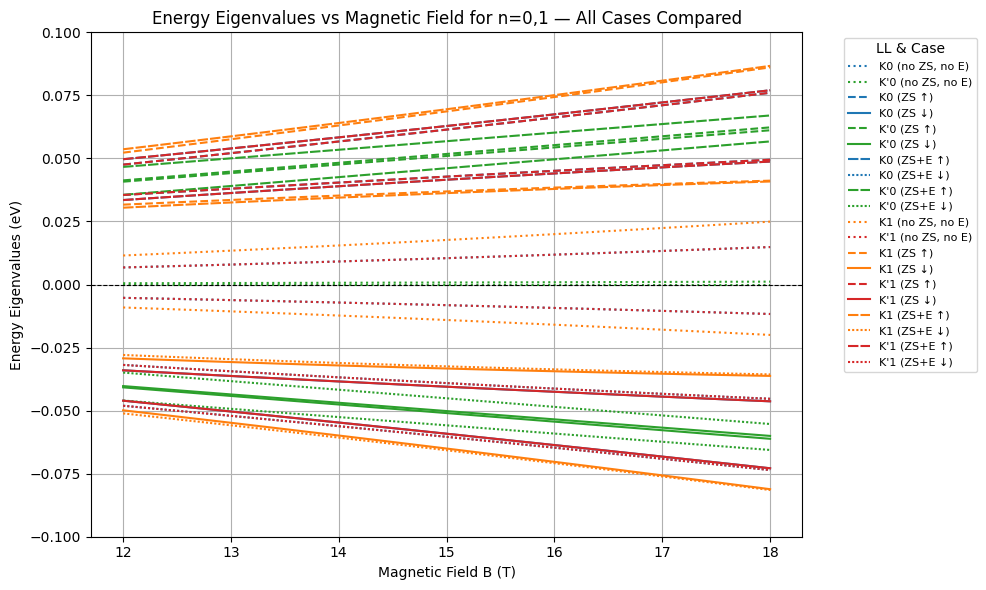

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define color for each Landau level
colors = {
    'K0': 'tab:blue',
    'K1': 'tab:orange',
    "K'0": 'tab:green',
    "K'1": 'tab:red'
}

# Line styles for different cases
linestyles = {
    'base': ':',
    'ZS_up': '--',
    'ZS_down': '-',
    'ZS_EF_up': (0, (5, 1)),      # Dash pattern
    'ZS_EF_down': (0, (1, 1))     # Dotted dash
}

for i, n in enumerate(n_values):
    label_K = f'K{n}'
    label_Kp = f"K'{n}"
    color_K = colors[label_K]
    color_Kp = colors[label_Kp]

    for mode in range(4):
        if mode == 0:  # Label only once
            # Base case
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=color_K, linestyle=linestyles['base'], label=f'{label_K} (no ZS, no E)')
            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=color_Kp, linestyle=linestyles['base'], label=f"{label_Kp} (no ZS, no E)")

            # ZS only
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_up'], label=f'{label_K} (ZS ↑)')
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_down'], label=f'{label_K} (ZS ↓)')
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_up'], label=f"{label_Kp} (ZS ↑)")
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_down'], label=f"{label_Kp} (ZS ↓)")

            # ZS + E
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_EF_up'], label=f'{label_K} (ZS+E ↑)')
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_EF_down'], label=f'{label_K} (ZS+E ↓)')
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_EF_up'], label=f"{label_Kp} (ZS+E ↑)")
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_EF_down'], label=f"{label_Kp} (ZS+E ↓)")
        else:
            # Same as above without labels
            ax.plot(B_values, all_eigenvalues_K_var_B[i, :, mode], color=color_K, linestyle=linestyles['base'])
            ax.plot(B_values, all_eigenvalues_K_prime_var_B[i, :, mode], color=color_Kp, linestyle=linestyles['base'])

            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_up'])
            ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_down'])
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_up'])
            ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_down'])

            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_up[i, :, mode], color=color_K, linestyle=linestyles['ZS_EF_up'])
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_down[i, :, mode], color=color_K, linestyle=linestyles['ZS_EF_down'])
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_EF_up'])
            ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i, :, mode], color=color_Kp, linestyle=linestyles['ZS_EF_down'])

ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title('Energy Eigenvalues vs Magnetic Field for n=0,1 — All Cases Compared')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, title="LL & Case")
ax.grid()
plt.tight_layout()
plt.show()

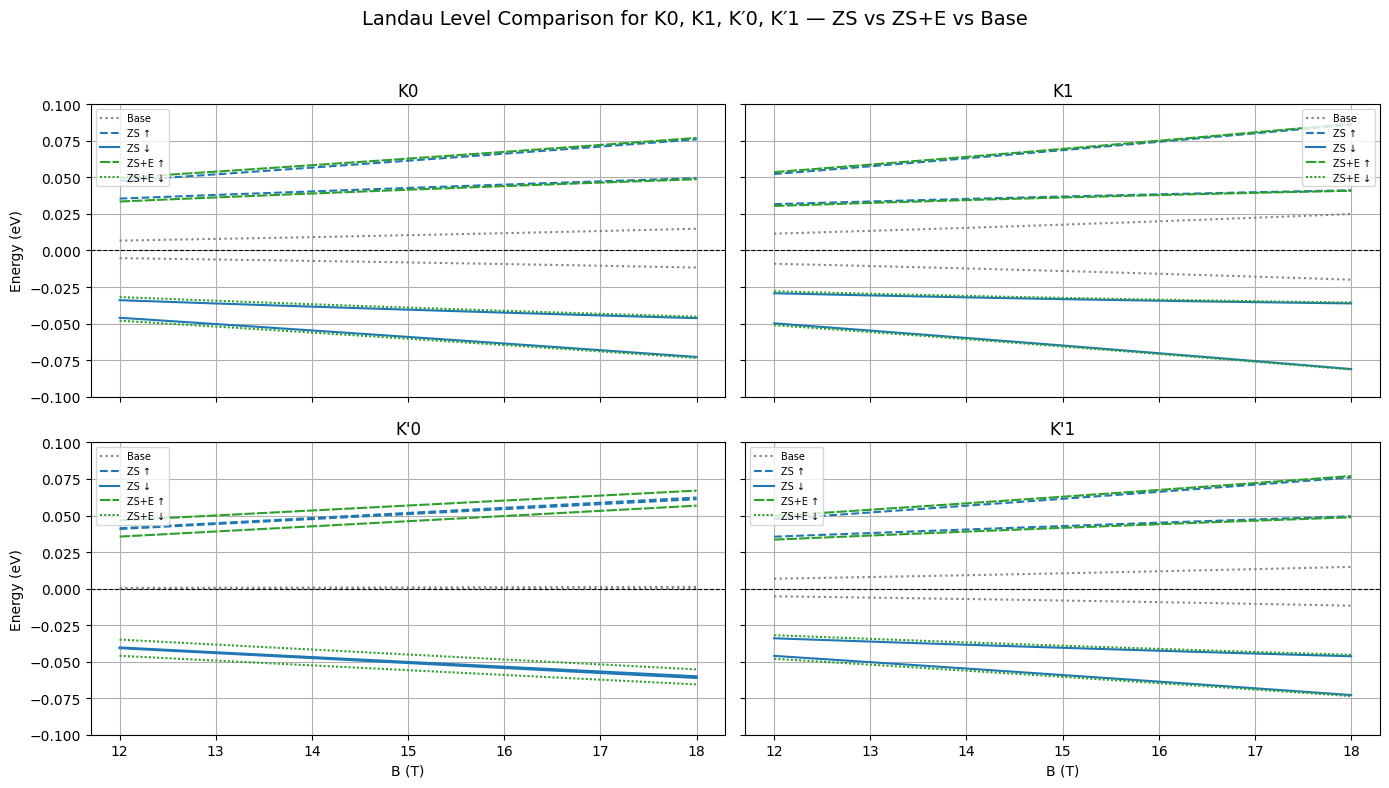

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axs = axs.flatten()

labels = ['K0', 'K1', "K'0", "K'1"]
case_styles = {
    'base': (':', 'tab:gray'),
    'ZS_up': ('--', 'tab:blue'),
    'ZS_down': ('-', 'tab:blue'),
    'ZS_EF_up': ((0, (5, 1)), 'tab:green'),
    'ZS_EF_down': ((0, (1, 1)), 'tab:green')
}

for idx, ax in enumerate(axs):
    if idx < 2:
        i = idx
        valley = 'K'
        eig_base = all_eigenvalues_K_var_B[i]
        eig_ZS_up = all_eigenvalues_ZS_K_var_B_spin_up[i]
        eig_ZS_down = all_eigenvalues_ZS_K_var_B_spin_down[i]
        eig_ZS_EF_up = all_eigenvalues_ZS_EF_K_var_B_spin_up[i]
        eig_ZS_EF_down = all_eigenvalues_ZS_EF_K_var_B_spin_down[i]
    else:
        i = idx - 2
        valley = "K'"
        eig_base = all_eigenvalues_K_prime_var_B[i]
        eig_ZS_up = all_eigenvalues_ZS_K_prime_var_B_spin_up[i]
        eig_ZS_down = all_eigenvalues_ZS_K_prime_var_B_spin_down[i]
        eig_ZS_EF_up = all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i]
        eig_ZS_EF_down = all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i]

    for mode in range(4):
        ax.plot(B_values, eig_base[:, mode], linestyle=case_styles['base'][0], color=case_styles['base'][1], label='Base' if mode == 0 else "")
        ax.plot(B_values, eig_ZS_up[:, mode], linestyle=case_styles['ZS_up'][0], color=case_styles['ZS_up'][1], label='ZS ↑' if mode == 0 else "")
        ax.plot(B_values, eig_ZS_down[:, mode], linestyle=case_styles['ZS_down'][0], color=case_styles['ZS_down'][1], label='ZS ↓' if mode == 0 else "")
        ax.plot(B_values, eig_ZS_EF_up[:, mode], linestyle=case_styles['ZS_EF_up'][0], color=case_styles['ZS_EF_up'][1], label='ZS+E ↑' if mode == 0 else "")
        ax.plot(B_values, eig_ZS_EF_down[:, mode], linestyle=case_styles['ZS_EF_down'][0], color=case_styles['ZS_EF_down'][1], label='ZS+E ↓' if mode == 0 else "")
        ax.set_ylim(-0.1,0.1)
        
    ax.set_title(f'{labels[idx]}')
    ax.grid(True)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    if idx in [2, 3]:
        ax.set_xlabel('B (T)')
    if idx in [0, 2]:
        ax.set_ylabel('Energy (eV)')
    ax.legend(fontsize=7)

plt.suptitle('Landau Level Comparison for K0, K1, K′0, K′1 — ZS vs ZS+E vs Base', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Now plotting Energy eigenvalues against Electric field at constant B

In [23]:
# Store eigenvalues for all n
all_eigenvalues_ZS_EF_K_var_E_spin_up = np.zeros((len(n_values), len(E_values), 4))
all_eigenvalues_ZS_EF_K_var_E_spin_down = np.zeros((len(n_values), len(E_values), 4))

all_eigenvalues_ZS_EF_K_prime_var_E_spin_up = np.zeros((len(n_values), len(E_values), 4))
all_eigenvalues_ZS_EF_K_prime_var_E_spin_down = np.zeros((len(n_values), len(E_values), 4))

In [24]:
def hamiltonian_matrix_ZS_EF_K_var_E(n, potential_diff):
    sqrt_n_plus_3 = np.sqrt(n + 3)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n = np.sqrt(n)
    omega_B = e * B_const / m_eff
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    delta_ZS = g * mu_B * B_const
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    l_B = np.sqrt((hbar * c) / (e * B_const))
    # potential_diff_const = e * E_const * d/2
    
    H_ZS_EF_K_var_E_spin_up = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime + delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2 + delta_ZS - potential_diff]
    ])

    H_ZS_EF_K_var_E_spin_down = np.array([
        [-delta_ZS + potential_diff, hbar_omega_B_n_plus_1, - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B),  hbar * (np.sqrt(2) * sqrt_n_plus_3 * v3 / l_B)],
        [hbar_omega_B_n_plus_1, delta_prime - delta_ZS + potential_diff, gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), gamma_1, delta_A2 + delta_prime - delta_ZS - potential_diff, hbar_omega_B_n_plus_2],
        [hbar * (np.sqrt(2) * sqrt_n * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar_omega_B_n_plus_2, delta_B2 - delta_ZS - potential_diff]
    ])
    return [H_ZS_EF_K_var_E_spin_up , H_ZS_EF_K_var_E_spin_down]

In [25]:
def hamiltonian_matrix_ZS_EF_K_prime_var_E(n, potential_diff):
    sqrt_n = np.sqrt(n)
    sqrt_n_plus_1 = np.sqrt(n + 1)
    sqrt_n_plus_2 = np.sqrt(n + 2)
    sqrt_n_plus_3 = np.sqrt(n + 3)
    omega_B = e * B_const / m_eff
    hbar_omega_B_n = hbar * omega_B * sqrt_n
    hbar_omega_B_n_plus_1 = hbar * omega_B * sqrt_n_plus_1
    hbar_omega_B_n_plus_2 = hbar * omega_B * sqrt_n_plus_2
    hbar_omega_B_n_plus_3 = hbar * omega_B * sqrt_n_plus_3
    delta_ZS = g * mu_B * B_const
    delta_A2 = V_A2_const
    delta_B2 = V_B2_const
    l_B = np.sqrt((hbar * c) / (e * B_const))
    # potential_diff_const = e * E_const * d/2
    
    H_ZS_EF_K_prime_var_E_spin_up = np.array([
        [delta_ZS + potential_diff, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime + delta_ZS + potential_diff, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, delta_A2 + delta_prime + delta_ZS - potential_diff, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2 + delta_ZS - potential_diff]
    ])

    H_ZS_EF_K_prime_var_E_spin_down = np.array([
        [-delta_ZS + potential_diff, hbar_omega_B_n_plus_2, - hbar * (np.sqrt(2) * sqrt_n_plus_2 * v4 / l_B), hbar * (np.sqrt(2) * sqrt_n_plus_2 * v3 / l_B)],
        [hbar_omega_B_n, delta_prime - delta_ZS + potential_diff, -gamma_1, - hbar * (np.sqrt(2) * sqrt_n_plus_3 * v4 / l_B)],
        [- hbar * (np.sqrt(2) * sqrt_n * v4 / l_B), -gamma_1, delta_A2 + delta_prime - delta_ZS - potential_diff, hbar_omega_B_n_plus_3],
        [hbar * (np.sqrt(2) * sqrt_n_plus_1 * v3 / l_B), - hbar * (np.sqrt(2) * sqrt_n_plus_1 * v4 / l_B), hbar_omega_B_n_plus_1, delta_B2 - delta_ZS - potential_diff]
    ])
    return [H_ZS_EF_K_prime_var_E_spin_up, H_ZS_EF_K_prime_var_E_spin_down]

In [26]:
# Compute eigenvalues
for i, n in enumerate(n_values):
    for j, E in enumerate(E_values):
        potential_diff = e * E * (d/2)
        
        H_ZS_EF_K_var_E_spin_up = hamiltonian_matrix_ZS_EF_K_var_E(n, potential_diff)[0]
        H_ZS_EF_K_var_E_spin_down = hamiltonian_matrix_ZS_EF_K_var_E(n, potential_diff)[1]
        
        H_ZS_EF_K_prime_var_E_spin_up = hamiltonian_matrix_ZS_EF_K_prime_var_E(n, potential_diff)[0]
        H_ZS_EF_K_prime_var_E_spin_down = hamiltonian_matrix_ZS_EF_K_prime_var_E(n, potential_diff)[1]
        
        eigvals_ZS_EF_K_var_E_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_var_E_spin_up) / e  # Convert to eV
        eigvals_ZS_EF_K_var_E_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_var_E_spin_down) / e  # Convert to eV
        eigvals_ZS_EF_K_prime_var_E_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_E_spin_up) / e  # Convert to eV
        eigvals_ZS_EF_K_prime_var_E_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_E_spin_down) / e  # Convert to eV
        
        all_eigenvalues_ZS_EF_K_var_E_spin_up[i, j, :] = eigvals_ZS_EF_K_var_E_spin_up
        all_eigenvalues_ZS_EF_K_var_E_spin_down[i, j, :] = eigvals_ZS_EF_K_var_E_spin_down
        
        all_eigenvalues_ZS_EF_K_prime_var_E_spin_up[i, j, :] = eigvals_ZS_EF_K_prime_var_E_spin_up
        all_eigenvalues_ZS_EF_K_prime_var_E_spin_down[i, j, :] = eigvals_ZS_EF_K_prime_var_E_spin_down

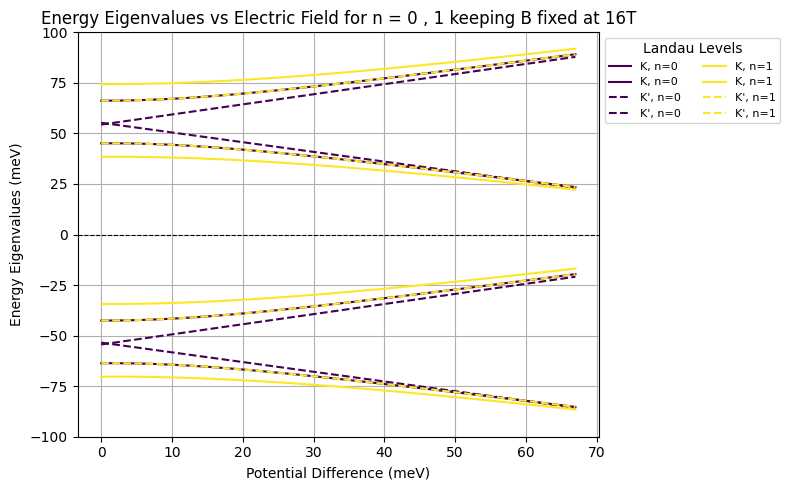

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))  # Color map for better visualization

for i, n in enumerate(n_values):
    for mode in range(4):  # There are 4 eigenvalues per n
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_var_E_spin_up[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_var_E_spin_down[i, :, mode], color=colors[i], linestyle='-', label=f'K, n={n}' if mode == 0 else "")
        
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_prime_var_E_spin_up[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")
        ax.plot(1e3 * E_values * d, 1e3 * all_eigenvalues_ZS_EF_K_prime_var_E_spin_down[i, :, mode], color=colors[i], linestyle='--', label=f"K', n={n}" if mode == 0 else "")

ax.set_xlabel('Potential Difference (meV)')
ax.set_ylabel('Energy Eigenvalues (meV)')
ax.set_ylim(-100,100)
ax.set_title('Energy Eigenvalues vs Electric Field for n = 0 , 1 keeping B fixed at 16T')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Show zero energy level
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Landau Levels")
ax.grid()

plt.tight_layout()

# Save the figure
# plt.savefig("energy_vs_E_at_constant_B.pdf", dpi=300, bbox_inches="tight")  # Saves as Pdf

plt.show()